In [2]:
import numpy as np
import numpy.linalg as la
import numpy.random as rand
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
from mpl_toolkits.mplot3d import Axes3D
import math
# from pydlm import dlm, autoReg, trend, seasonality
# from pydlm import modelTuner
from statsmodels.tsa.stattools import adfuller
from matplotlib import cm
from scipy.integrate import odeint
from scipy import stats
from EDMtoolkit import *
from modelSystems import *
import datetime

plt.rcParams['text.usetex'] = True

%load_ext autoreload
%autoreload 2
%matplotlib notebook

# Generate Series from a Linear Model

In [3]:
def generateLinearSeries(length=200,pro_noise=0.0, obs_noise=0.1, ns=False):
    
    start = 1/6 # rand.random(1)[0]
    if ns:
        theta = lambda t: (0.5+t)*np.pi/6
    else:
        theta = lambda t: np.pi/6
    A = lambda theta: np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
    
    X = np.zeros((length,2))
    X[0] = rand.normal(2)

    for i in range(length-1):
        t = i / (length-1) if ns else 0
        X[i+1] = (A(theta(t)) @ X[i]) + rand.normal(0,pro_noise,2)
    
    ts = standardize(X[:,0]) + (rand.normal(0,1,length) * obs_noise)
    
    # return standardize(ts) if ns else standardize(ts)
    return standardize(ts + np.linspace(0,2,num=length)) if ns else standardize(ts)

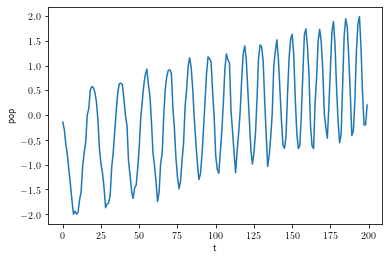

In [4]:
Xr = generateLinearSeries(ns=True)
plotTS(Xr)

In [5]:
# Null hypothesis: data are nonstationary, rejected if p<0.5
# adfuller(Xr)[1]

In [6]:
# General Hyperparameters
T = 200
o_n = 0.1
N_replicates = 100
reduction = 2 ** 8

<IPython.core.display.Javascript object>


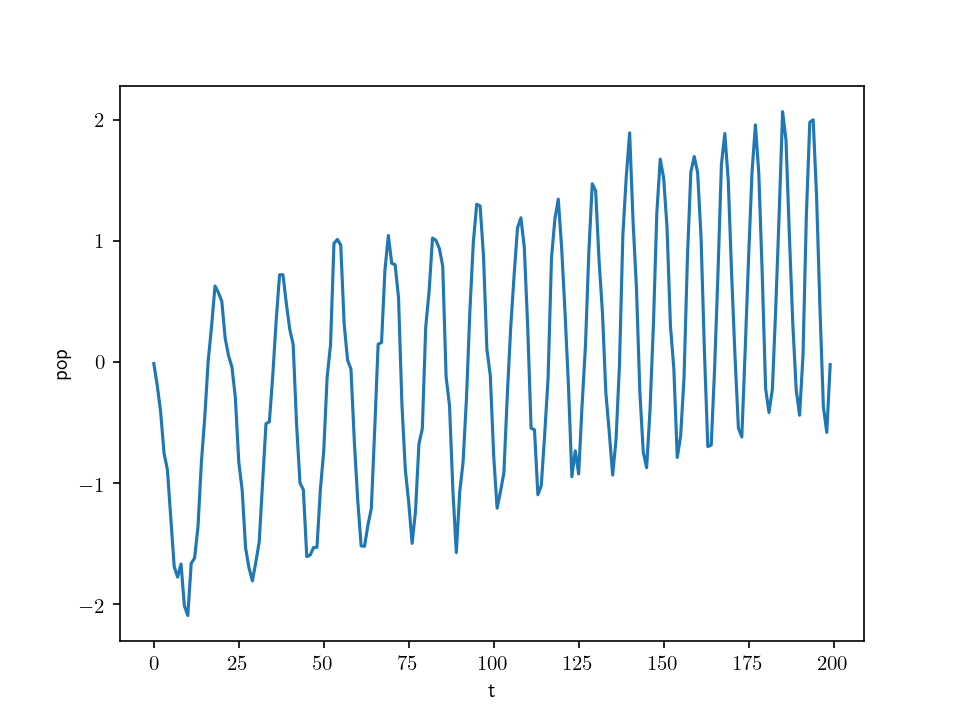

<IPython.core.display.Javascript object>


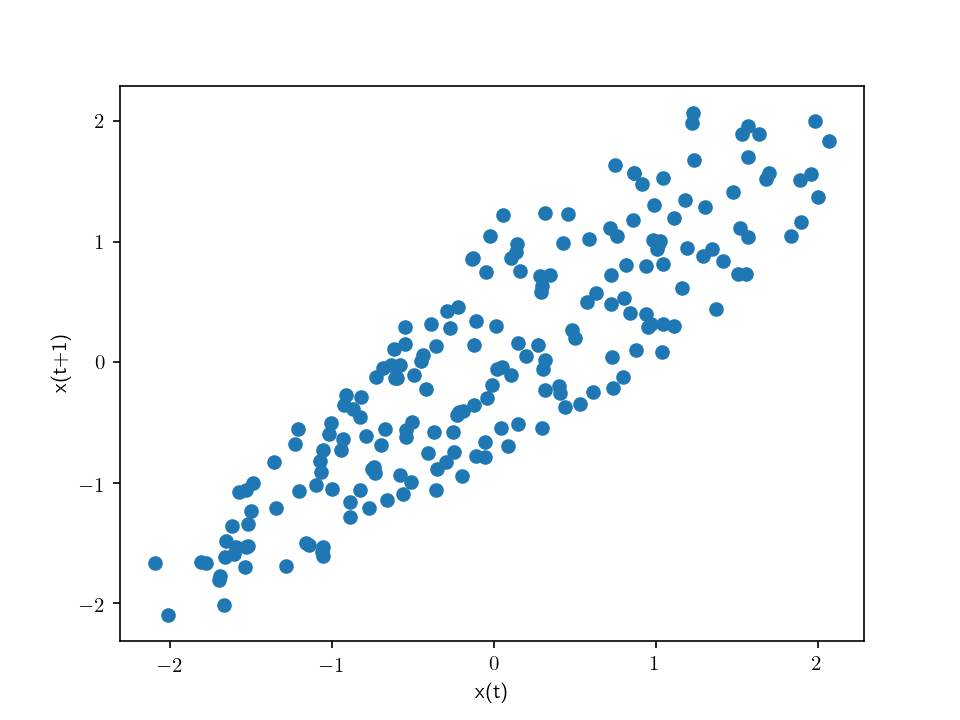

<IPython.core.display.Javascript object>


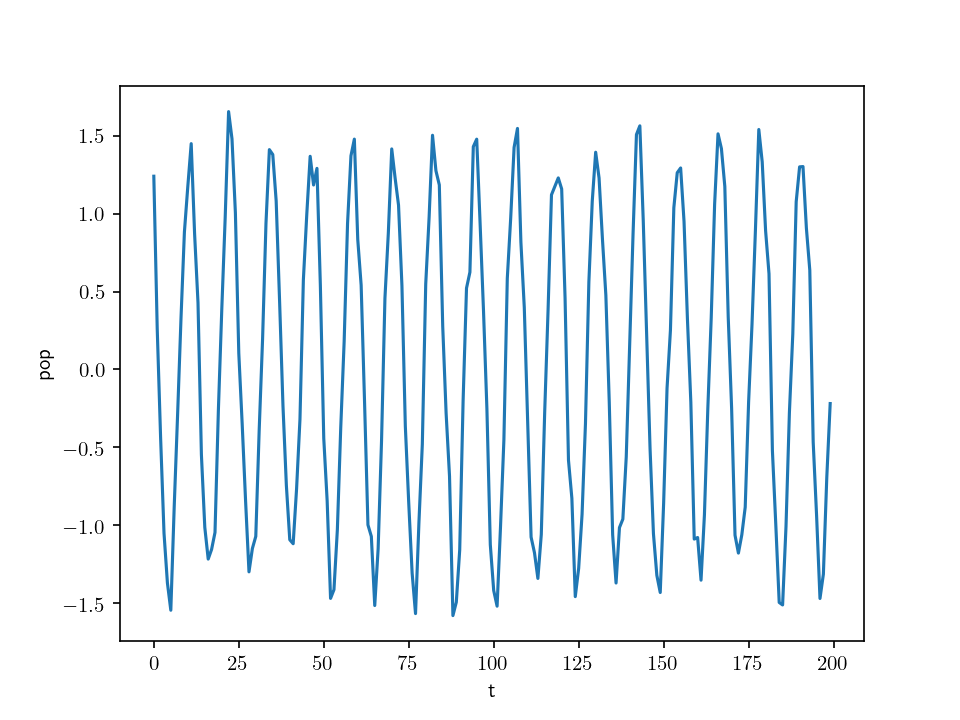

<IPython.core.display.Javascript object>


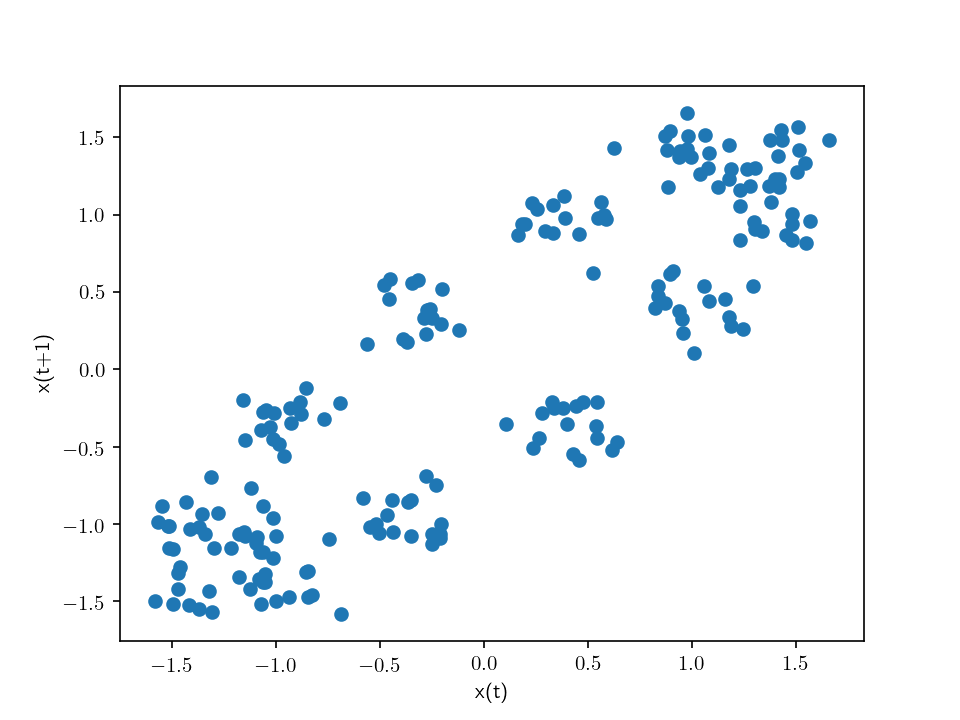

In [83]:
# Linear Model
E_max = 2

# ts_std is the standard deviation of the time series which
# is normalized to 1
log_std = 1

# nonstationarity status, delta, theta, r_sqrd, delta_DLM, r_sqrd_DLM
results = np.zeros((N_replicates * 2, 6))
results_index = 0

for NS in [True, False]:
    for i in range(N_replicates):
        Xr = generateLinearSeries(length=T, obs_noise=o_n, ns=NS)
        Xr += (rand.normal(0,1,T) * log_std * o_n)
        
        #plotTS(Xr)
        #poincare2d(Xr)
        
        """
        delta_agg, theta_agg, r_sqrd = get_delta_agg(Xr, E_max, return_forecast_skill=True)
        delta_agg_DLM, theta_agg_DLM, r_sqrd_DLM = get_delta_agg(Xr, E_max, return_forecast_skill=True, theta_fixed=True)
        # dickey_fuller_p = adfuller(Xr)[1]
        
        results[results_index] = np.array([int(NS), delta_agg, theta_agg, r_sqrd, delta_agg_DLM, r_sqrd_DLM])
        results_index += 1
        
np.savetxt(f"linear_NSMap_vs_DLM.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")
"""

In [9]:
# Observation Noise versus Nonstationarity Rate
r_list = (lambda t: 3.75, lambda t: 3.75 - 0.75 * t / T)
E_max = 2
N_replicates = 100

# log_std is calculated as the standard deviation on a stationary logistic map series with T=200 and r=3.75

# nonstationarity status, delta, theta, r_sqrd, delta_DLM, r_sqrd_DLM
results = np.zeros((N_replicates * len(r_list), 6))
results_index = 0

for ri, r in enumerate(r_list):
    for i in range(N_replicates):
        x0 = rand.rand(1)
        Xr = standardize(generateTimeSeriesDiscrete("LogisticP", x0, tlen=T, nsargs=(r,)))
        Xr += (rand.normal(0,1,T) * o_n)[:,None]

        delta_agg, theta_agg, r_sqrd = get_delta_agg(Xr, E_max, return_forecast_skill=True)
        delta_agg_DLM, theta_agg_DLM, r_sqrd_DLM = get_delta_agg(Xr, E_max, return_forecast_skill=True, theta_fixed=True)
        # dickey_fuller_p = adfuller(Xr)[1]
        
        results[results_index] = np.array([ri, delta_agg, theta_agg, r_sqrd, delta_agg_DLM, r_sqrd_DLM])
        results_index += 1
            
np.savetxt(f"logistic_NSMap_vs_DLM.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")

In [41]:
# Observation Noise versus Nonstationarity Rate
n_years = T / 12
end = n_years * 60
E_max = 3
settlingTime = 2 ** 9

N_replicates = 100

b1_list = (lambda t: 3, lambda t: 3 + 3* t / end)

# log_std is calculated as the standard deviation on a stationary hastings powell map series with T=200 and b1=3
log_std = 0.20682984252169215

# nonstationarity status, delta, theta, r_sqrd, delta_DLM, r_sqrd_DLM
results = np.zeros((N_replicates * len(b1_list), 6))
results_index = 0

for b1i, b1 in enumerate(b1_list):
    for i in range(N_replicates):
        x0 = np.array([0.1,0.4,9]) + rand.random(3)
        Xr = generateTimeSeriesContinuous('HastingsPowellP', x0, end=end, tlen = T, nsargs=(b1,), 
                                          reduction = reduction, settlingTime=settlingTime, 
                                          process_noise=0)[:,0,None]
        Xr += (rand.normal(0,1,T) * log_std * o_n)[:,None]
        # plotTS(Xr)
        
        delta_agg, theta_agg, r_sqrd = get_delta_agg(Xr, E_max, return_forecast_skill=True)
        delta_agg_DLM, theta_agg_DLM, r_sqrd_DLM = get_delta_agg(Xr, E_max, return_forecast_skill=True, theta_fixed=True)
        
        results[results_index] = np.array([b1i, delta_agg, theta_agg, r_sqrd, delta_agg_DLM, r_sqrd_DLM])
        results_index += 1
    print(b1i)
            
np.savetxt(f"hastings_powell_NSMap_vs_DLM.csv", results, fmt="%0.4f,%0.4f,%0.4f,%0.4f,%0.4f,%0.4f")

0
1


# Mockup of delta vs theta graph

In [7]:
# fill with data of results for Hastings Powell and Logistic in Round 2
l_data = np.loadtxt("logistic_NSMap_vs_DLM.csv",delimiter=',')
hp_data = np.loadtxt("hastings_powell_NSMap_vs_DLM.csv",delimiter=',')
lin_data = np.loadtxt("linear_NSMap_vs_DLM.csv",delimiter=',')

l_nonstat = np.log(l_data[l_data[:,0] == 1][:,1:3]+1)
l_stat = np.log(l_data[l_data[:,0] == 0][:,1:3]+1)
hp_nonstat = np.log(hp_data[hp_data[:,0] == 1][:,1:3]+1)
hp_stat = np.log(hp_data[hp_data[:,0] == 0][:,1:3]+1)
lin_nonstat = np.log(lin_data[lin_data[:,0] == 1][:,1:3]+1)
lin_stat = np.log(lin_data[lin_data[:,0] == 0][:,1:3]+1)

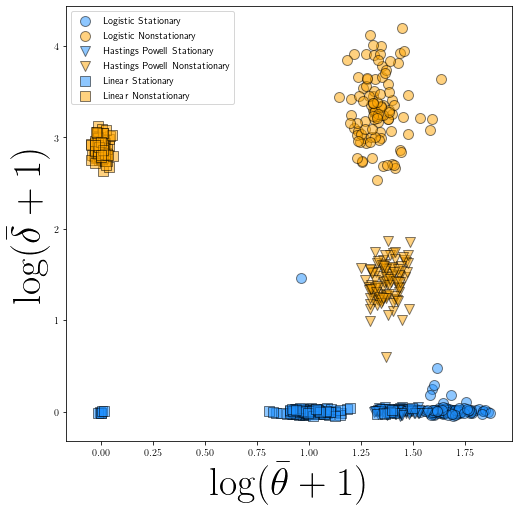

In [20]:
size = 100
alpha = 0.5
dither = 0.02

dithering = lambda: rand.normal(0,dither,size=size)

dvt_fig, dvt_ax = plt.subplots(1, figsize=(8,8))
dvt_ax.set_xlabel(r"$\log(\bar{\theta}+1)$",fontsize=40)
dvt_ax.set_ylabel(r"$\log(\bar{\delta}+1)$",fontsize=40)
#dvt_ax.set_xticks([])
#dvt_ax.set_yticks([])

dvt_ax.scatter(l_stat[:,1]+dithering(), l_stat[:,0]+dithering(), c="dodgerblue", s=size, edgecolors="black", label="Logistic Stationary", alpha=alpha)
dvt_ax.scatter(l_nonstat[:,1]+dithering(), l_nonstat[:,0]+dithering(), c="orange", s=size, edgecolors="black", label="Logistic Nonstationary", alpha=alpha)
dvt_ax.scatter(hp_stat[:,1]+dithering(), hp_stat[:,0]+dithering(), c="dodgerblue",marker="v", s=size, edgecolors="black", label="Hastings Powell Stationary", alpha=alpha)
dvt_ax.scatter(hp_nonstat[:,1]+dithering(), hp_nonstat[:,0]+dithering(), c="orange",marker="v", s=size, edgecolors="black", label="Hastings Powell Nonstationary", alpha=alpha)
dvt_ax.scatter(lin_stat[:,1]+dithering(), lin_stat[:,0]+dithering(), c="dodgerblue",marker="s", s=size, edgecolors="black", label="Linear Stationary", alpha=alpha)
dvt_ax.scatter(lin_nonstat[:,1]+dithering(), lin_nonstat[:,0]+dithering(), c="orange",marker="s", s=size, edgecolors="black", label="Linear Nonstationary", alpha=alpha)

plt.legend()
plt.show()

In [95]:
# DLM Version

l_nonstat_DLM = l_data[l_data[:,0] == 1][:,[False,True,False,True,False,False]]
l_stat_DLM = l_data[l_data[:,0] == 0][:,[False,True,False,True,False,False]]
hp_nonstat_DLM = hp_data[hp_data[:,0] == 1][:,[False,True,False,True,False,False]]
hp_stat_DLM = hp_data[hp_data[:,0] == 0][:,[False,True,False,True,False,False]]
lin_nonstat_DLM = lin_data[lin_data[:,0] == 1][:,[False,True,False,True,False,False]]
lin_stat_DLM = lin_data[lin_data[:,0] == 0][:,[False,True,False,True,False,False]]
l_nonstat_NS = l_data[l_data[:,0] == 1][:,4:]
l_stat_NS = l_data[l_data[:,0] == 0][:,4:]
hp_nonstat_NS = hp_data[hp_data[:,0] == 1][:,4:]
hp_stat_NS = hp_data[hp_data[:,0] == 0][:,4:]
lin_nonstat_NS = lin_data[lin_data[:,0] == 1][:,4:]
lin_stat_NS = lin_data[lin_data[:,0] == 0][:,4:]

<IPython.core.display.Javascript object>


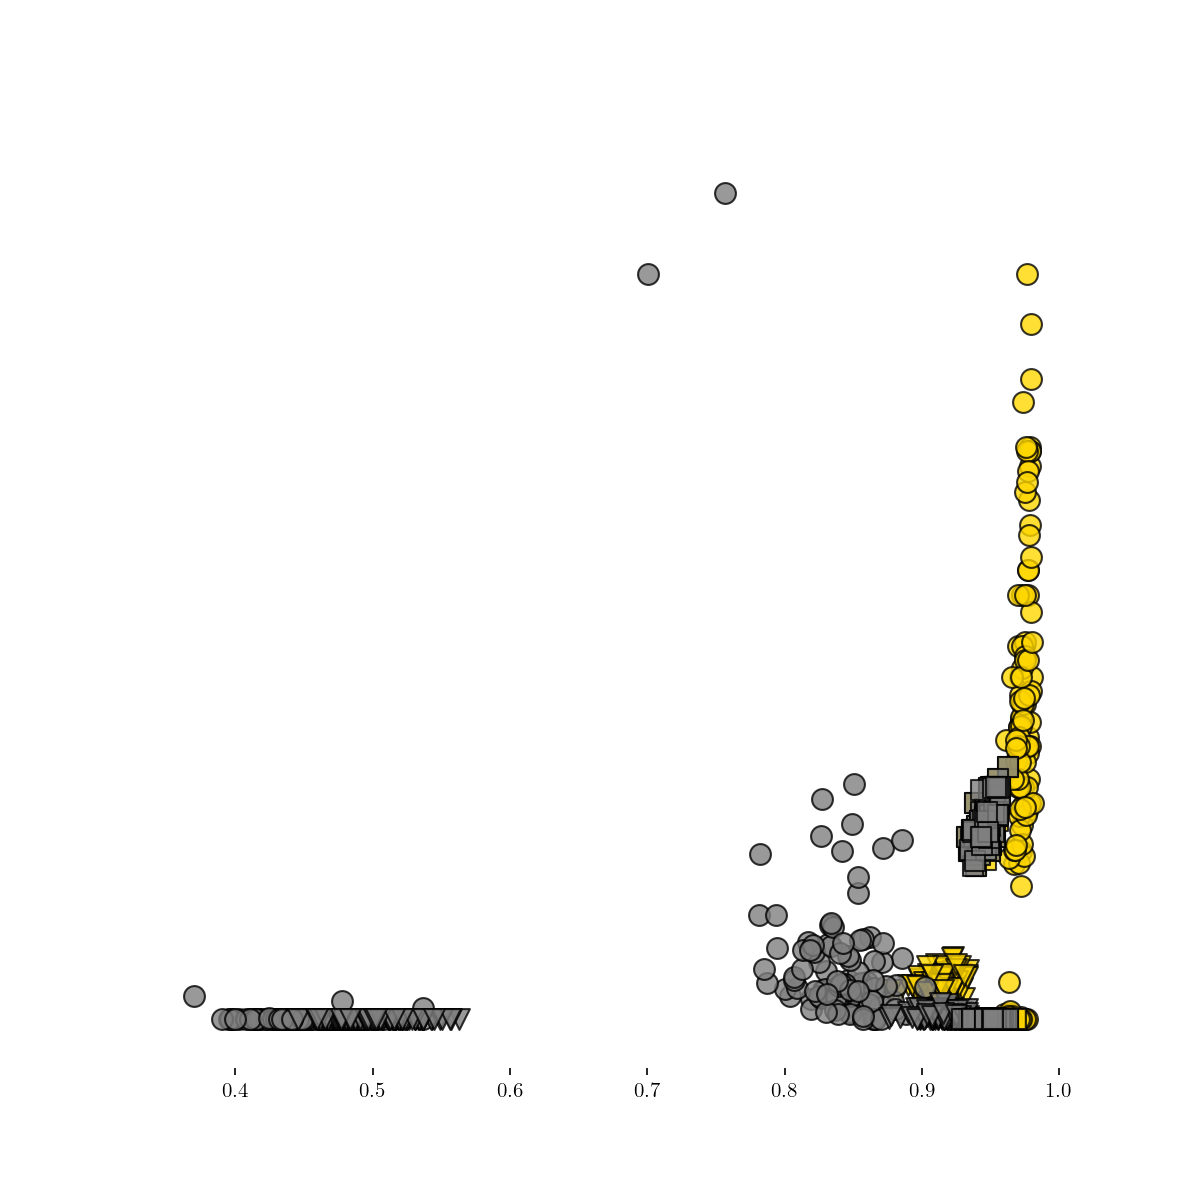

In [101]:
size = 100

d_fig, d_ax = plt.subplots(1, figsize=(8,8))
d_ax.set_xlabel(r"r$",fontsize=40)
d_ax.set_ylabel(r"$\log(\delta+1)$",fontsize=40)
#dvt_ax.set_xticks([])
#dvt_ax.set_yticks([])

# DLM = grey, NSMap = gold

d_ax.scatter(l_stat_DLM[:,1], l_stat_DLM[:,0], c="gold", s=size, edgecolors="black", label="Logistic Stationary", alpha=0.8)
d_ax.scatter(l_nonstat_DLM[:,1], l_nonstat_DLM[:,0], c="gold", s=size, edgecolors="black", label="Logistic Nonstationary", alpha=0.8)
d_ax.scatter(hp_stat_DLM[:,1], hp_stat_DLM[:,0], c="gold",marker="v", s=size, edgecolors="black", label="Hastings Powell Stationary", alpha=0.8)
d_ax.scatter(hp_nonstat_DLM[:,1], hp_nonstat_DLM[:,0], c="gold",marker="v", s=size, edgecolors="black", label="Hastings Powell Nonstationary", alpha=0.8)
d_ax.scatter(lin_stat_DLM[:,1], lin_stat_DLM[:,0], c="gold",marker="s", s=size, edgecolors="black", label="Linear Stationary", alpha=0.8)
d_ax.scatter(lin_nonstat_DLM[:,1], lin_nonstat_DLM[:,0], c="gold",marker="s", s=size, edgecolors="black", label="Linear Nonstationary", alpha=0.8)

d_ax.scatter(l_stat_NS[:,1], l_stat_NS[:,0], c="grey", s=size, edgecolors="black", label="Logistic Stationary", alpha=0.8)
d_ax.scatter(l_nonstat_NS[:,1], l_nonstat_NS[:,0], c="grey", s=size, edgecolors="black", label="Logistic Nonstationary", alpha=0.8)
d_ax.scatter(hp_stat_NS[:,1], hp_stat_NS[:,0], c="grey",marker="v", s=size, edgecolors="black", label="Hastings Powell Stationary", alpha=0.8)
d_ax.scatter(hp_nonstat_DLM[:,1], hp_nonstat_NS[:,0], c="grey",marker="v", s=size, edgecolors="black", label="Hastings Powell Nonstationary", alpha=0.8)
d_ax.scatter(lin_stat_NS[:,1], lin_stat_NS[:,0], c="grey",marker="s", s=size, edgecolors="black", label="Linear Stationary", alpha=0.8)
d_ax.scatter(lin_nonstat_NS[:,1], lin_nonstat_NS[:,0], c="grey",marker="s", s=size, edgecolors="black", label="Linear Nonstationary", alpha=0.8)

plt.legend()
plt.show()

In [90]:
np.mean(l_data[:,3])

0.969881

In [91]:
np.mean(hp_data[:,3])

0.9252594999999999

<IPython.core.display.Javascript object>


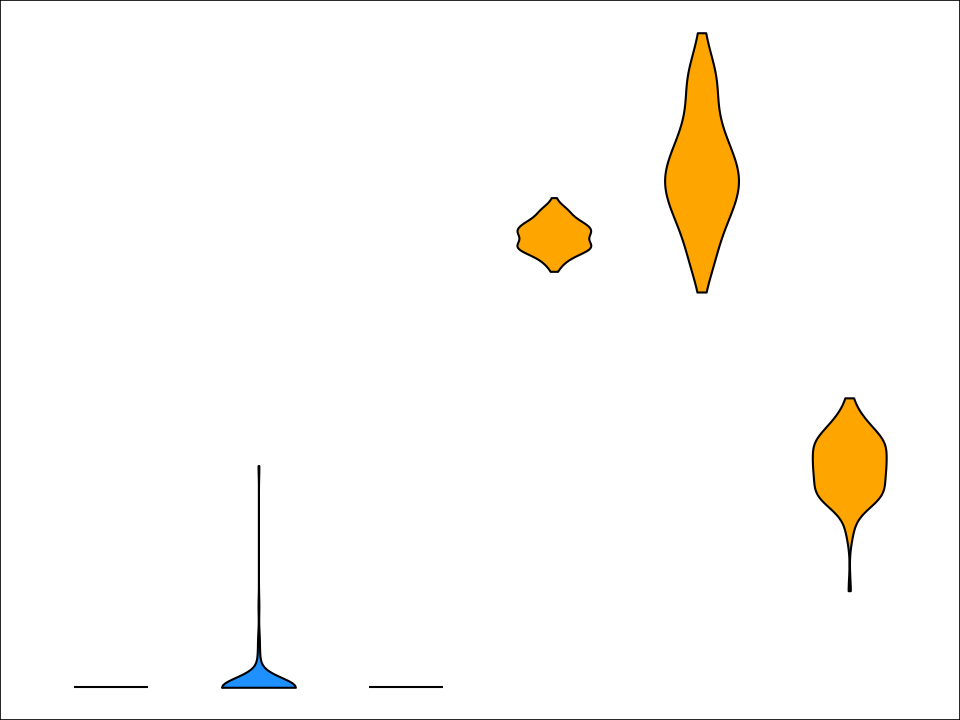

In [92]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
bp = ax.violinplot([lin_stat, l_stat, hp_stat, lin_nonstat, l_nonstat, hp_nonstat],showextrema=False)

for i, pc in enumerate(bp["bodies"]):
    if i >= 3:
        pc.set_facecolor("orange")
        pc.set_edgecolor("black")
    else:
        pc.set_facecolor("dodgerblue")
        pc.set_edgecolor("black")
    pc.set_alpha(1)

labels = ["Stationary Linear", "Stationary Linear","Stationary Linear","Stationary Linear","Stationary Linear","Stationary Linear"]
  
ax.set_xticks(np.arange(1, len(labels) + 1))
ax.set_xticklabels(labels)
ax.set_xlim(0.25, len(labels) + 0.75)
    
plt.show()

In [ ]:
l_nonstat = np.log(l_data[l_data[:,0] == 1][:,1]+1)
l_stat = np.log(l_data[l_data[:,0] == 0][:,1]+1)
hp_nonstat = np.log(hp_data[hp_data[:,0] == 1][:,1]+1)
hp_stat = np.log(hp_data[hp_data[:,0] == 0][:,1]+1)
lin_nonstat = np.log(lin_data[lin_data[:,0] == 1][:,1]+1)
lin_stat = np.log(lin_data[lin_data[:,0] == 0][:,1]+1)

# Old Code

In [ ]:
def rand_disc(n, minimum=0,maximum=1):
    return np.sign(rand.uniform(-1,1,size=n))*rand.uniform(minimum,maximum,size=n)
    # return np.exp(rand.uniform(size=n)*np.pi*2j)
    # return rand.uniform(minimum,maximum,size=n)*np.exp(rand.uniform(size=n)*np.pi*2j)

def calculate_coeff(roots):
    
    # contains the phi which satisfies (1-phi*z)=0 when z=root
    coefs_root_form = -1 / roots
    subset_sizes = range(1,len(coefs_root_form)+1)
    
    # sum all 1 element subsets, then 2 element subsets, ... n element subsets
    return np.array([np.sum(np.prod(np.array(list(itertools.combinations(coefs_root_form, subset_size))),axis=1)) for subset_size in subset_sizes])
    
def eval_poly(coefs, value):
    return 1 + np.sum(coefs * (value ** np.arange(1,len(coefs)+1)))

In [ ]:
np.set_printoptions(suppress=True, precision=3)

roots = rand_disc(10,2,3)
coefs = calculate_coeff(roots)

print(np.array(list([eval_poly(coefs,root) for root in roots])))

In [ ]:
tlen = 100
X = rand_disc(tlen)
l = 6

ar_roots = rand_disc(l,np.pi,4)
ar_coeffs = -calculate_coeff(ar_roots)

for i in range(tlen-l):
    X[i+l] = np.sum(ar_coeffs * X[i:i+l])
    
plotTS(X)
ar_roots